## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# White - Pink - Red noise classification

## Loading data

In [2]:
wpr = pd.read_table('./noise/clf_noise.txt', header=None, sep=' ', names=['Hurst', 'Length', 'Colour_idx', 'Colour'])
wpr.head()

,Hurst,Length,Colour_idx,Colour
0,0.632314,100,0,white
1,0.526672,110,0,white
2,0.527252,120,0,white
3,0.433123,130,0,white
4,0.590089,140,0,white


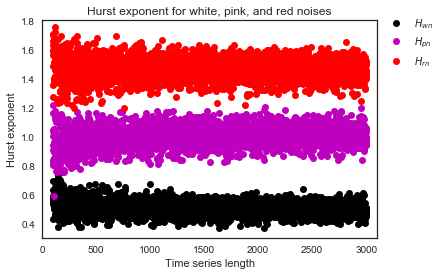

In [3]:
L_plot = wpr['Length']
H_plot = wpr['Hurst']
plt.plot(L_plot[wpr['Colour_idx'] == 0], H_plot[wpr['Colour_idx'] == 0], 'ok', label='$H_{wn}$')
plt.plot(L_plot[wpr['Colour_idx'] == 1], H_plot[wpr['Colour_idx'] == 1], 'om', label='$H_{pn}$')
plt.plot(L_plot[wpr['Colour_idx'] == 2], H_plot[wpr['Colour_idx'] == 2], 'or', label='$H_{rn}$')
plt.xlim(0, 3100)
plt.ylim(0.3, 1.8)
plt.title('Hurst exponent for white, pink, and red noises')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

## Sklearn imports

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA, KernelPCA

## Train and test sets

In [5]:
X = wpr[['Length', 'Hurst']]
y = wpr['Colour_idx']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (6547, 2)
y_train shape: (6547,)
X_test shape: (2183, 2)
y_test shape: (2183,)


## Train and test sets plots

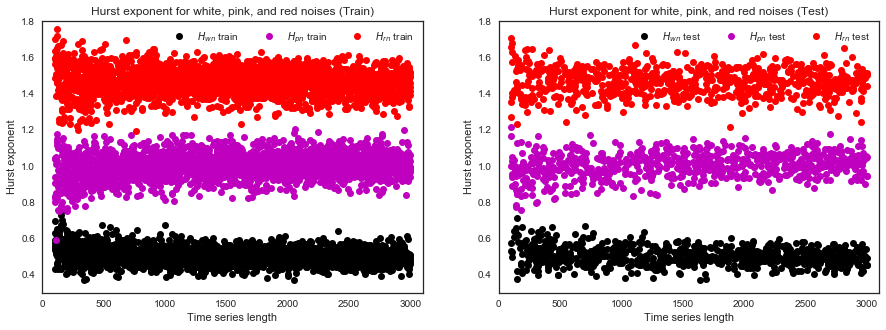

In [6]:
L_train = X_train['Length']
H_train = X_train['Hurst']
L_test = X_test['Length']
H_test = X_test['Hurst']
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(L_train[y_train == 0], H_train[y_train == 0], 'ok', label='$H_{wn}$ train')
plt.plot(L_train[y_train == 1], H_train[y_train == 1], 'om', label='$H_{pn}$ train')
plt.plot(L_train[y_train == 2], H_train[y_train == 2], 'or', label='$H_{rn}$ train')
plt.xlim(0, 3100)
plt.ylim(0.3, 1.8)
plt.title('Hurst exponent for white, pink, and red noises (Train)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')
plt.legend(ncol=3, loc=1)
plt.subplot(122)
plt.plot(L_test[y_test == 0], H_test[y_test == 0], 'ok', label='$H_{wn}$ test')
plt.plot(L_test[y_test == 1], H_test[y_test == 1], 'om', label='$H_{pn}$ test')
plt.plot(L_test[y_test == 2], H_test[y_test == 2], 'or', label='$H_{rn}$ test')
plt.xlim(0, 3100)
plt.ylim(0.3, 1.8)
plt.title('Hurst exponent for white, pink, and red noises (Test)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')
plt.legend(ncol=3, loc=1)

# Logistic regression

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
log_reg = LogisticRegression(multi_class='multinomial', penalty='l2')
grid_values = {'C':[0.01, 0.1, 1, 10, 100], 'solver':['newton-cg', 'lbfgs']}
grid = GridSearchCV(log_reg, param_grid=grid_values, scoring='f1_micro', cv=3)
grid.fit(X_scaled, y_train)
print('Grid best parameter (F1): {}'.format(grid.best_params_))
print('Grid best score (F1): {}'.format(grid.best_score_))
grid = grid.best_estimator_
X_test_scaled = scaler.transform(X_test)
y_pred = grid.predict(X_test_scaled)
acc = grid.score(X_test_scaled, y_test)
rec = recall_score(y_test, y_pred, average='micro')
prec = precision_score(y_test, y_pred, average='micro')
conf_mtx = confusion_matrix(y_test, y_pred)
print('Accuracy: {}'.format(acc))
print('Recall: {}'.format(rec))
print('Precision: {}'.format(prec))
print(classification_report(y_test, y_pred))
print(conf_mtx)

Grid best parameter (F1): {'C': 100, 'solver': 'newton-cg'}
Grid best score (F1): 0.9993890331449519
Accuracy: 0.9986257443884563
Recall: 0.9986257443884563
Precision: 0.9986257443884563
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  0 686   1]
 [  0   2 719]]


In [34]:
### values of length and hurst
values = scaler.transform([[1034, 1.27]])
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if grid.predict(values) == 0 else('pink' if grid.predict(values) == 1 else 'red')))
### predict probabilities for input values (returns array, first value for white, second value for pink, and third value for red)
print('Classes probabilities: white -> {:.3f}, pink -> {:.3f}, red -> {:.3f}'.format(grid.predict_proba(values)[0,0], grid.predict_proba(values)[0,1], grid.predict_proba(values)[0,2]))

Predicted class: red
Classes probabilities: white -> 0.000, pink -> 0.007, red -> 0.993


Text(0,0.5,'Hurst exponent')

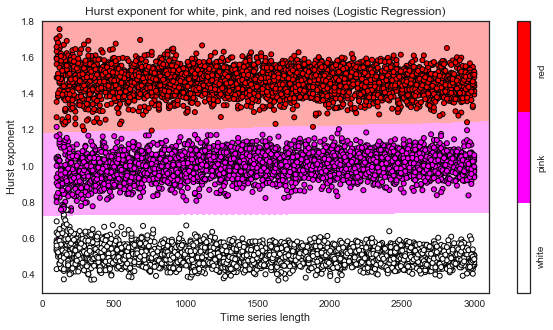

In [54]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.01
lim_new = scaler.transform([[lx, by], [rx, ty]])
xx, yy = np.mgrid[lim_new[0, 0]:lim_new[1, 0]+step:step, lim_new[0, 1]:lim_new[1, 1]+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = grid.predict(pnts).reshape(xx.shape)
mean_tr = scaler.mean_
std_tr = np.sqrt(scaler.var_)
xx_new = xx * std_tr[0] + mean_tr[0]
yy_new = yy * std_tr[1] + mean_tr[1]
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx_new, yy_new, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (Logistic Regression)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

# SVM

In [37]:
# select the preprocessing pipeline operations and transform data
svm_pipe = Pipeline([('scaler', StandardScaler())])
X_new = svm_pipe.fit_transform(X_train)
# select and fit classifier
grid_values = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['sigmoid', 'rbf', 'poly'], 'gamma':[0.01, 1, 100]}
clf = SVC()
grid = GridSearchCV(clf, param_grid=grid_values, scoring='f1_micro', cv=3)
grid.fit(X_new, y_train)
print('Grid best parameter (F1): {}'.format(grid.best_params_))
print('Grid best score (F1): {}'.format(grid.best_score_))
grid = grid.best_estimator_
print(grid)
# transform and predict new values
X_test_new = svm_pipe.transform(X_test)
y_pred = grid.predict(X_test_new)
# metrics
print('MSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Accuracy: {}'.format(grid.score(X_test_new, y_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Grid best parameter (F1): {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Grid best score (F1): 0.9993890331449519
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
MSE: 0.03026830698430012
Accuracy: 0.9990838295923041
Recall: 0.9990838295923041
Precision: 0.9990838295923041
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  0 686   1]
 [  0   1 720]]


In [38]:
### values of length and hurst
values = svm_pipe.transform([[1034, 0.75]])
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if grid.predict(values) == 0 else('pink' if grid.predict(values) == 1 else 'red')))

Predicted class: pink


Text(0,0.5,'Hurst exponent')

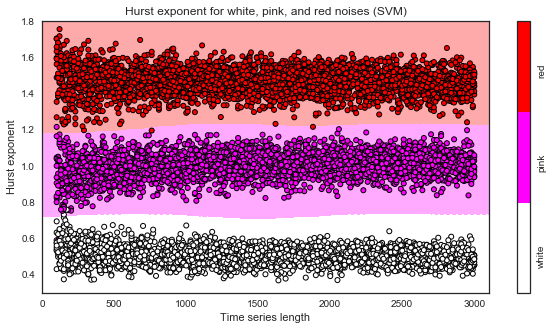

In [39]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.01
lim_new = svm_pipe.transform([[lx, by], [rx, ty]])
xx, yy = np.mgrid[lim_new[0, 0]:lim_new[1, 0]+step:step, lim_new[0, 1]:lim_new[1, 1]+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = grid.predict(pnts).reshape(xx.shape)
mean_tr = svm_pipe.named_steps['scaler'].mean_
std_tr = np.sqrt(svm_pipe.named_steps['scaler'].var_)
xx_new = xx * std_tr[0] + mean_tr[0]
yy_new = yy * std_tr[1] + mean_tr[1]
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx_new, yy_new, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (SVM)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

In [63]:
### validation curve
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = y_train
train_sizes, train_scores, test_scores = learning_curve(SVC(C=1, gamma=1, kernel='rbf'),
                                                        X_scaled, y_scaled, train_sizes=np.arange(50, 3000, 50),
                                                        cv=5, shuffle=True)

Text(0,0.5,'Score')

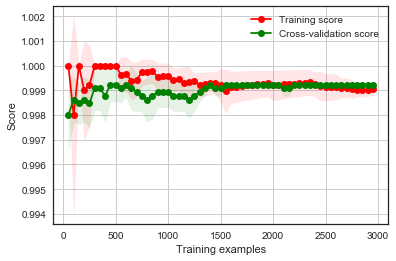

In [64]:
### learning curve plot
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.xlabel('Training examples')
plt.ylabel('Score')

# Decision Tree

In [7]:
grid_values = {'max_depth':[1, 2, 3, 5, 10, 20]}
tree_clf = DecisionTreeClassifier()
grid = GridSearchCV(tree_clf, param_grid=grid_values, scoring='f1_micro', cv=3)
grid.fit(X_train, y_train)
print('Grid best parameter (F1): {}'.format(grid.best_params_))
print('Grid best score (F1): {}'.format(grid.best_score_))
grid = grid.best_estimator_
print(grid)
# transform and predict new values
y_pred = grid.predict(X_test)
# metrics
print('MSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Accuracy: {}'.format(grid.score(X_test, y_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Grid best parameter (F1): {'max_depth': 2}
Grid best score (F1): 0.9990835497174279
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
MSE: 0.02140292512363475
Accuracy: 0.9995419147961521
Recall: 0.9995419147961521
Precision: 0.9995419147961521
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  0 686   1]
 [  0   0 721]]


In [8]:
### values of length and hurst
values = [[134, 1.0]]
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if grid.predict(values) == 0 else('pink' if grid.predict(values) == 1 else 'red')))
### predict probabilities for input values (returns array, first value for white, second value for pink, and third value for red)
print('Classes probabilities: white -> {:.3f}, pink -> {:.3f}, red -> {:.3f}'.format(grid.predict_proba(values)[0,0], grid.predict_proba(values)[0,1], grid.predict_proba(values)[0,2]))

Predicted class: pink
Classes probabilities: white -> 0.000, pink -> 0.999, red -> 0.001


Text(0,0.5,'Hurst exponent')

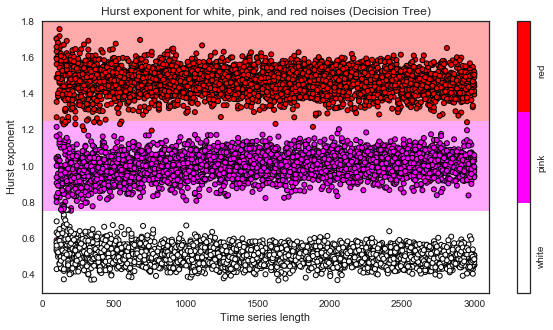

In [9]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.05
xx, yy = np.mgrid[lx:rx+step:step, by:ty+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = grid.predict(pnts).reshape(xx.shape)
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx, yy, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (Decision Tree)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

In [10]:
export_graphviz(grid, out_file='./noise/tree_multinoise.dot', feature_names=['Length', 'Hurst'], class_names=['White', 'Pink', 'Red'], rounded=True, filled=True)
!dot -Tpdf ./noise/tree_multinoise.dot -o ./noise/tree_multinoise.pdf

# Random Forest

In [11]:
grid_values = {'max_depth':[1, 2, 3, 5, 10, 20]}
rnd_clf = RandomForestClassifier(n_estimators=100, bootstrap=True, n_jobs=-1, random_state=0)
grid = GridSearchCV(rnd_clf, param_grid=grid_values, scoring='f1_micro', cv=3)
grid.fit(X_train, y_train)
print('Grid best parameter (F1): {}'.format(grid.best_params_))
print('Grid best score (F1): {}'.format(grid.best_score_))
grid = grid.best_estimator_
print(grid)
# transform and predict new values
y_pred = grid.predict(X_test)
# metrics
print('MSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Accuracy: {}'.format(grid.score(X_test, y_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Grid best parameter (F1): {'max_depth': 10}
Grid best score (F1): 0.9992362914311899
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
MSE: 0.03026830698430012
Accuracy: 0.9990838295923041
Recall: 0.9990838295923041
Precision: 0.9990838295923041
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  1 685   1]
 [  0   0 721]]


In [12]:
### features importance
print('Length importance: {}'.format(grid.feature_importances_[0]))
print('Hurst importance: {}'.format(grid.feature_importances_[1]))

Length importance: 0.0027446755441387933
Hurst importance: 0.9972553244558613


In [13]:
### values of length and hurst
values = [[134, 1.0]]
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if grid.predict(values) == 0 else('pink' if grid.predict(values) == 1 else 'red')))
### predict probabilities for input values (returns array, first value for white, second value for pink, and third value for red)
print('Classes probabilities: white -> {:.3f}, pink -> {:.3f}, red -> {:.3f}'.format(grid.predict_proba(values)[0,0], grid.predict_proba(values)[0,1], grid.predict_proba(values)[0,2]))

Predicted class: pink
Classes probabilities: white -> 0.000, pink -> 1.000, red -> 0.000


Text(0,0.5,'Hurst exponent')

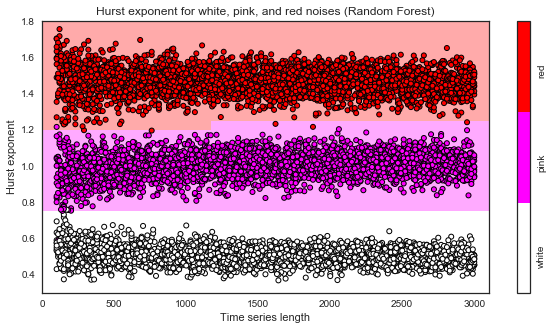

In [14]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.05
xx, yy = np.mgrid[lx:rx+step:step, by:ty+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = grid.predict(pnts).reshape(xx.shape)
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx, yy, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (Random Forest)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

# KNN

In [16]:
# select the preprocessing pipeline operations and transform data
knn_pipe = Pipeline([('scaler', StandardScaler())])
X_new = knn_pipe.fit_transform(X_train)
# select and fit classifier
grid_values = {'n_neighbors': [2, 3, 5, 10, 20]}
knn_clf = KNeighborsClassifier(n_jobs=-1)
grid = GridSearchCV(knn_clf, param_grid=grid_values, scoring='f1_micro', cv=3)
grid.fit(X_new, y_train)
print('Grid best parameter (F1): {}'.format(grid.best_params_))
print('Grid best score (F1): {}'.format(grid.best_score_))
grid = grid.best_estimator_
print(grid)
# transform and predict new values
X_test_new = knn_pipe.transform(X_test)
y_pred = grid.predict(X_test_new)
# metrics
print('MSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Accuracy: {}'.format(grid.score(X_test_new, y_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Grid best parameter (F1): {'n_neighbors': 5}
Grid best score (F1): 0.9993890331449519
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
MSE: 0.02140292512363475
Accuracy: 0.9995419147961521
Recall: 0.9995419147961521
Precision: 0.9995419147961521
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  0 686   1]
 [  0   0 721]]


In [19]:
### values of length and hurst
values = knn_pipe.transform([[1034, 1.0]])
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if grid.predict(values) == 0 else('pink' if grid.predict(values) == 1 else 'red')))
### predict probabilities for input values (returns array, first value for white, second value for pink, and third value for red)
print('Classes probabilities: white -> {:.3f}, pink -> {:.3f}, red -> {:.3f}'.format(grid.predict_proba(values)[0,0], grid.predict_proba(values)[0,1], grid.predict_proba(values)[0,2]))

Predicted class: pink
Classes probabilities: white -> 0.000, pink -> 1.000, red -> 0.000


Text(0,0.5,'Hurst exponent')

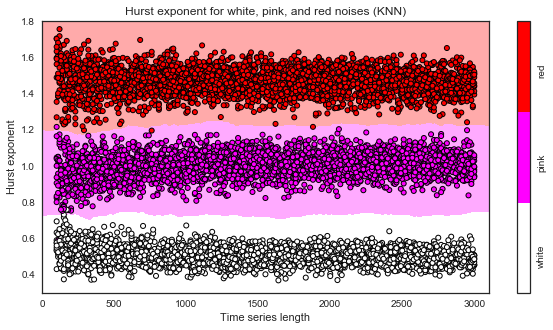

In [20]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.01
lim_new = knn_pipe.transform([[lx, by], [rx, ty]])
xx, yy = np.mgrid[lim_new[0, 0]:lim_new[1, 0]+step:step, lim_new[0, 1]:lim_new[1, 1]+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = grid.predict(pnts).reshape(xx.shape)
mean_tr = knn_pipe.named_steps['scaler'].mean_
std_tr = np.sqrt(knn_pipe.named_steps['scaler'].var_)
xx_new = xx * std_tr[0] + mean_tr[0]
yy_new = yy * std_tr[1] + mean_tr[1]
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx_new, yy_new, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (KNN)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

# Naive Bayes

In [27]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
# metrics
print('MSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('Accuracy: {}'.format(clf_nb.score(X_test, y_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Precision: {}'.format(precision_score(y_test, y_pred, average='micro')))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

MSE: 0.02140292512363475
Accuracy: 0.9995419147961521
Recall: 0.9995419147961521
Precision: 0.9995419147961521
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       775
          1       1.00      1.00      1.00       687
          2       1.00      1.00      1.00       721

avg / total       1.00      1.00      1.00      2183

[[775   0   0]
 [  0 687   0]
 [  0   1 720]]


In [29]:
### values of length and hurst
values = [[134, 0.75]]
### predict for input values (returns 0 for white, 1 for pink, and 2 for red)
print('Predicted class: {}'.format('white' if clf_nb.predict(values) == 0 else('pink' if clf_nb.predict(values) == 1 else 'red')))
### predict probabilities for input values (returns array, first value for white, second value for pink, and third value for red)
print('Classes probabilities: white -> {:.3f}, pink -> {:.3f}, red -> {:.3f}'.format(clf_nb.predict_proba(values)[0,0], clf_nb.predict_proba(values)[0,1], clf_nb.predict_proba(values)[0,2]))

Predicted class: pink
Classes probabilities: white -> 0.021, pink -> 0.979, red -> 0.000


Text(0,0.5,'Hurst exponent')

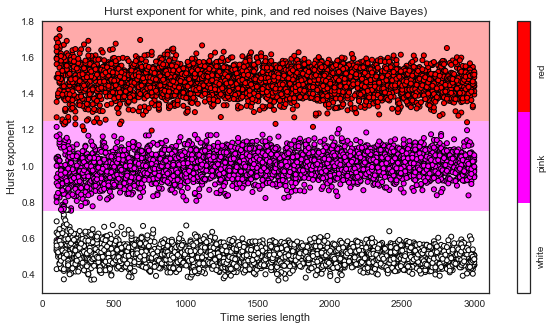

In [30]:
### decision boundary plot
lx = 0
rx = 3100
by = 0.3
ty = 1.8
step = 0.05
xx, yy = np.mgrid[lx:rx+step:step, by:ty+step:step]
pnts = np.c_[xx.ravel(), yy.ravel()]
probs = clf_nb.predict(pnts).reshape(xx.shape)
# Create color maps
cmap_light = ListedColormap(['#FFFFFF', '#FFAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FFFFFF', '#FF00FF', '#FF0000'])
plt.figure(figsize=(10, 5))
plt.pcolormesh(xx, yy, probs, cmap=cmap_light)
plt.scatter(X['Length'], X['Hurst'], c=y, cmap=cmap_bold, edgecolor='k', s=25, linewidth=1)
cbar = plt.colorbar()
cbar.set_ticks([0.33, 1.00, 1.66])
cbar.ax.set_yticklabels(['white', 'pink', 'red'], rotation=90)
plt.xlim(lx, rx)
plt.ylim(by, ty)
plt.title('Hurst exponent for white, pink, and red noises (Naive Bayes)')
plt.xlabel('Time series length')
plt.ylabel('Hurst exponent')

# Voting Classifier

In [34]:
scaler = StandardScaler()
X_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True) ### if voting='soft', since it needs to calculate probabilities (False in voting='hard')
knn_clf = KNeighborsClassifier()
nb_clf = GaussianNB()
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('sf', svm_clf),
                                         ('kf', knn_clf), ('nf', nb_clf)], voting='soft')
for clf in (log_clf, svm_clf, knn_clf, rnd_clf, nb_clf, voting_clf):
    clf.fit(X_new, y_train)
    y_pred = clf.predict(X_test_new)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9990838295923041
SVC 0.9990838295923041
KNeighborsClassifier 0.9995419147961521
RandomForestClassifier 0.9990838295923041
GaussianNB 0.9990838295923041
VotingClassifier 0.9995419147961521


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
